In [115]:
import os 
import json 


import numpy as np
import pandas as pd
import matplotlib.ticker as mticker # For log scale formatting if used
import matplotlib.pyplot as plt

In [125]:
model = "nn"
dataset = "blood_transfusion" 
nr_test = "2"
sm_method = "ei"


path_experiments = '/Users/razvanip/Library/CloudStorage/OneDrive-Personal/Research/Llambo/trials'

filepath = os.path.join(path_experiments, f"{dataset}_{model}_{sm_method}_{nr_test}", '0acq_attention_vectors.jsonl')
json_filepath = os.path.join(path_experiments, f"{dataset}_{model}_{sm_method}_{nr_test}", '0_search_info.json')

In [126]:
attention_data_loaded = []

with open(filepath, 'r') as f_jsonl:
    for line in f_jsonl:
        record = json.loads(line)
        # Optionally convert the attention matrix back to a NumPy array or Tensor
        if 'attention_matrix' in record and record['attention_matrix'] is not None:
            record['attention_matrix'] = np.array(record['attention_matrix'])
        attention_data_loaded.append(record)

In [127]:
attention_data_loaded[0]

{'n_history': 5,
 'seq_len': 864,
 'source_tag': 'ACQ',
 'entropy': 4.157166481018066,
 'attention_matrix': array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [7.53906250e-01, 2.44140625e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [7.03125000e-01, 4.12597656e-02, 2.53906250e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [5.11718750e-01, 4.60815430e-03, 1.71661377e-04, ...,
         2.03125000e-01, 0.00000000e+00, 0.00000000e+00],
        [4.45312500e-01, 3.69262695e-03, 1.59263611e-04, ...,
         3.97949219e-02, 2.22656250e-01, 0.00000000e+00],
        [4.37500000e-01, 4.02832031e-03, 1.26838684e-04, ...,
         8.11767578e-03, 7.03125000e-02, 2.01171875e-01]])}

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns # Optional

def plot_attention_heatmap_focused(
    attention_matrix,
    num_tokens_to_show=500, # Max number of tokens for rows/cols to display
    title="Attention Heatmap",
    token_labels=None, # Optional: FULL list of original token labels for the whole sequence
    cmap='viridis',
    global_scale_vmin=0.0, # Default: Ensure scale starts at 0
    global_scale_vmax=1.0 # Default: Ensure scale ends at 1 (good for probabilities)
):
    """
    Plots a heatmap for a potentially large attention matrix, focusing on the
    interactions among the last `num_tokens_to_show` tokens, while keeping
    the color scale relative to the specified global_scale_vmin/vmax range.

    Args:
        attention_matrix (np.array): The FULL 2D attention matrix to plot.
        num_tokens_to_show (int): The size of the square window (last N x last N tokens)
                                  to display. If None or >= seq_len, plots the whole matrix.
        title (str): The title for the plot.
        token_labels (list, optional): FULL list of token strings for original axis labels.
        cmap (str): Colormap to use for the heatmap.
        global_scale_vmin (float): Min value for the color scale (often 0 for attention).
        global_scale_vmax (float): Max value for the color scale (often 1 for attention).
    """
    if attention_matrix is None:
        print(f"Warning: Cannot plot None attention matrix for title: {title}")
        return
    if attention_matrix.ndim != 2 or attention_matrix.shape[0] != attention_matrix.shape[1]:
         print(f"Warning: attention_matrix must be square 2D. Got shape {attention_matrix.shape}. Skipping plot.")
         return


    original_seq_len = attention_matrix.shape[0]

    # Determine if we need to plot the full matrix or a focused view
    plot_full_matrix = (num_tokens_to_show is None or
                        num_tokens_to_show <= 0 or
                        num_tokens_to_show >= original_seq_len)

    if plot_full_matrix:
        matrix_to_plot = attention_matrix
        start_index = 0
        plot_title = title + f" (Full {original_seq_len}x{original_seq_len})"
        effective_plot_dim = original_seq_len
    else:
        # Slice the matrix to get the last num_tokens_to_show interactions
        start_index = max(0, original_seq_len - num_tokens_to_show) # Ensure start_index is not negative
        actual_num_shown = original_seq_len - start_index # Handle cases where matrix is smaller than num_tokens_to_show
        matrix_to_plot = attention_matrix[start_index:, start_index:]
        plot_title = title 
        effective_plot_dim = actual_num_shown

    # --- Plotting ---
    # Adjust figure size dynamically based on the plotted dimension, with limits
    fig_base_size = 6
    fig_scale_factor = max(0.01, min(0.03, 10 / effective_plot_dim)) # Adjust scaling factor
    fig_size_inch = max(fig_base_size, effective_plot_dim * fig_scale_factor)
    fig_size_inch = min(fig_size_inch, 25) # Cap max size to prevent enormous plots
    figsize = (fig_size_inch + 2, fig_size_inch) # Add width for colorbar

    plt.figure(figsize=figsize)

    ax = sns.heatmap(
        matrix_to_plot,
        cmap=cmap,
        cbar_kws={'label': 'Attention Weight'},
        square=True, # Keep aspect ratio square for the heatmap cells
        vmin=global_scale_vmin, # <<< Use the global scale min
        vmax=global_scale_vmax, # <<< Use the global scale max
        annot=False # Annotations are usually too dense for large (e.g., 500x500) matrices
    )

    plt.title(plot_title)
    plt.xlabel("Token Index (Attended To / Key)")
    plt.ylabel("Token Index (Attending From / Query)")

    # --- Adjust ticks and labels to show ORIGINAL indices ---
    # Determine tick positions within the plotted submatrix (0 to effective_plot_dim-1)
    num_ticks = min(10, effective_plot_dim) # Aim for ~10 ticks max for clarity
    tick_step = max(1, effective_plot_dim // num_ticks)
    sub_matrix_tick_indices = np.arange(0, effective_plot_dim, step=tick_step)

    # Calculate corresponding original indices
    original_indices_labels = np.arange(start_index, original_seq_len, step=tick_step)

    # Set ticks and labels
    ax.set_xticks(sub_matrix_tick_indices + 0.5) # Center ticks on cells
    ax.set_yticks(sub_matrix_tick_indices + 0.5)
    ax.set_xticklabels(original_indices_labels)
    ax.set_yticklabels(original_indices_labels)

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Optional: Add grid lines for very large plots if needed
    # ax.grid(True, which='major', axis='both', linestyle='-', color='k', linewidth=0.1)

    plt.tight_layout()
    plt.show()



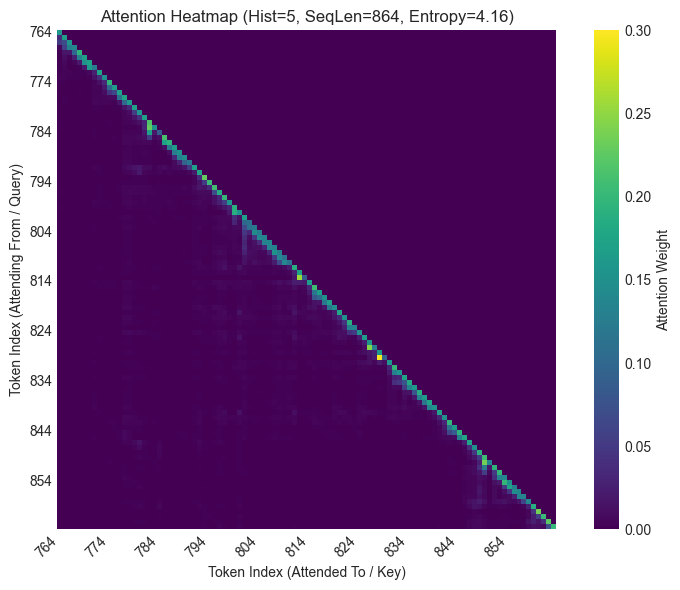

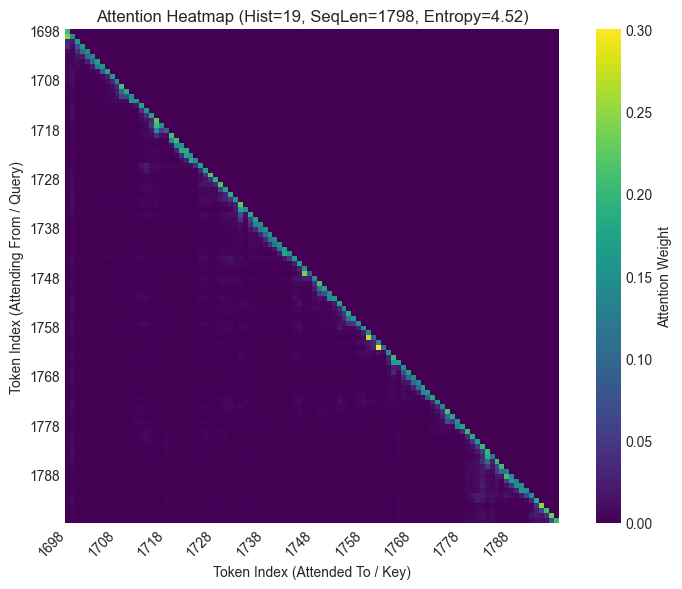

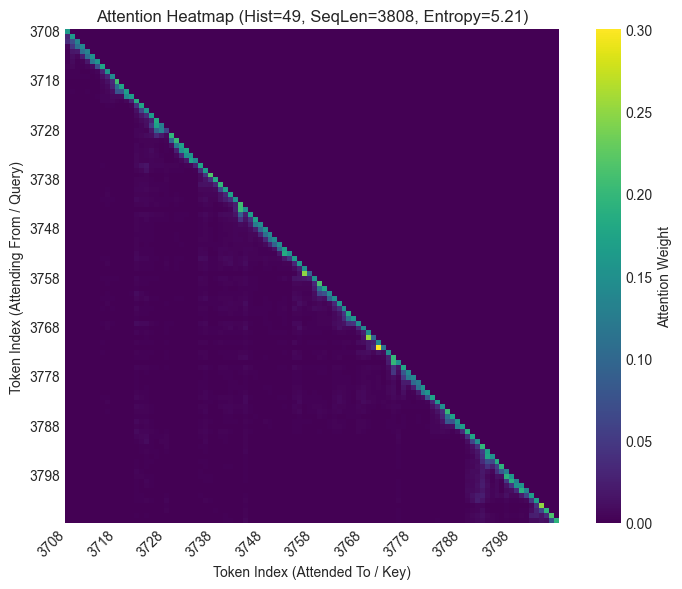

In [132]:

# --- Example Usage ---
# Assuming 'attention_data_loaded' contains your records with 'attention_matrix'


positions = [0, 3, 9]


for pos in positions: 
    record_to_plot = attention_data_loaded[pos] # Example: choose a record
    if 'attention_matrix' in record_to_plot and record_to_plot['attention_matrix'] is not None:
        full_matrix = record_to_plot['attention_matrix']
        hist = record_to_plot.get('n_history', 'N/A')
        seq_len = record_to_plot.get('seq_len', full_matrix.shape[0])
        entropy= record_to_plot.get('entropy')


        plot_attention_heatmap_focused(
            attention_matrix=full_matrix,
            num_tokens_to_show=100, # Focus on last 500x500
            title=f"Attention Heatmap (Hist={hist}, SeqLen={seq_len}, Entropy={entropy:.2f})",
            cmap='viridis',
            global_scale_vmin=0.0, # Explicitly set 0-1 scale
            global_scale_vmax=0.3
        )
    else:
        print("Selected record does not contain a valid attention matrix.")



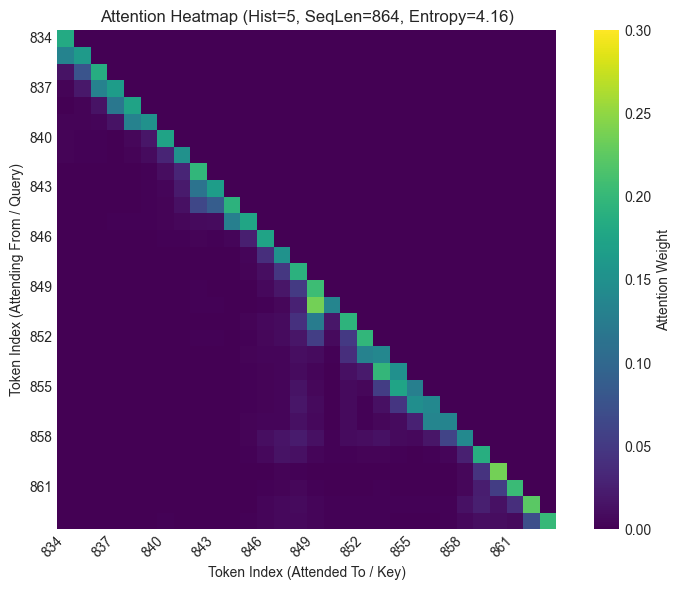

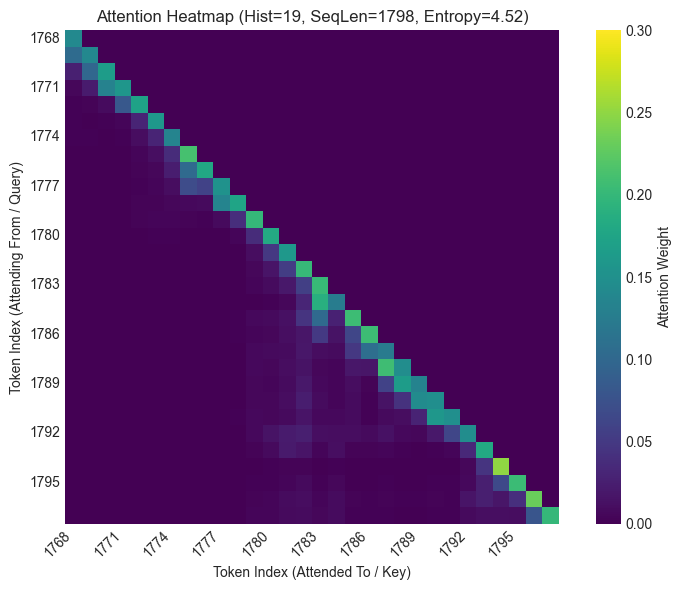

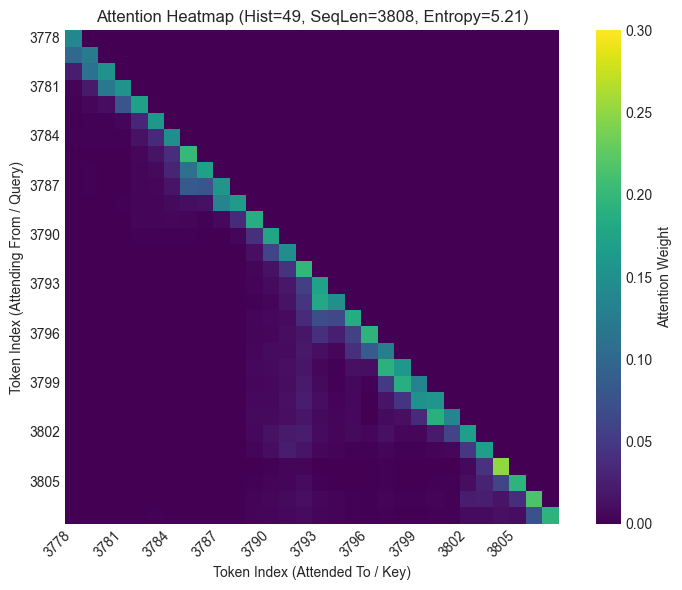

In [133]:
positions = [0, 3, 9]


for pos in positions: 
    record_to_plot = attention_data_loaded[pos] # Example: choose a record
    if 'attention_matrix' in record_to_plot and record_to_plot['attention_matrix'] is not None:
        full_matrix = record_to_plot['attention_matrix']
        hist = record_to_plot.get('n_history', 'N/A')
        seq_len = record_to_plot.get('seq_len', full_matrix.shape[0])
        entropy= record_to_plot.get('entropy')


        plot_attention_heatmap_focused(
            attention_matrix=full_matrix,
            num_tokens_to_show=30, # Focus on last 500x500
            title=f"Attention Heatmap (Hist={hist}, SeqLen={seq_len}, Entropy={entropy:.2f})",
            cmap='viridis',
            global_scale_vmin=0.0, # Explicitly set 0-1 scale
            global_scale_vmax=0.3
        )
    else:
        print("Selected record does not contain a valid attention matrix.")

In [143]:
def plot_entropy(json_filepath):

    PLOT_X_LOG_SCALE = False # Set True to use log2 scale for x-axis like paper's Fig 3
    SOURCE_TAG_TO_PLOT = 'ACQ' # Ensure we only plot data logged from ACQ steps

    with open(json_filepath, 'r') as f:
        search_info = json.load(f)

    attention_data = search_info.get('acq_attention_results') # Check primary key first

    # --- 2. Prepare DataFrame ---
    df = pd.DataFrame(attention_data)
    print("\n--- Raw Data Sample ---")
    print(df.head())
    print("----------------------")


    # --- 3. Data Cleaning/Filtering ---
    # Ensure required columns exist
    required_cols = {'n_history', 'entropy'}
    if not required_cols.issubset(df.columns):
        print(f"ERROR: DataFrame missing required columns. Needed: {required_cols}. Found: {df.columns}")
        exit()

    # Filter for the specific source if 'source' column exists
    if 'source' in df.columns and SOURCE_TAG_TO_PLOT:
        print(f"Filtering results for source = '{SOURCE_TAG_TO_PLOT}'...")
        df_filtered = df[df['source'] == SOURCE_TAG_TO_PLOT].copy()
        print(f"  {len(df_filtered)} entries remaining after source filtering.")
    else:
        df_filtered = df.copy() # Use all data if no source column or no filter needed

    # Drop rows with NaN entropy or invalid n_history
    initial_rows = len(df_filtered)
    df_filtered = df_filtered.dropna(subset=['entropy'])
    df_filtered = df_filtered[df_filtered['n_history'] >= 0] # Filter out placeholder -1 if used

    if initial_rows > len(df_filtered):
        print(f"Removed {initial_rows - len(df_filtered)} rows with NaN entropy or invalid n_history.")

    if df_filtered.empty:
        print("ERROR: No valid attention data remaining after cleaning.")
        exit()

    # Ensure types are correct
    df_filtered['n_history'] = df_filtered['n_history'].astype(int)
    df_filtered['entropy'] = df_filtered['entropy'].astype(float)


    # --- 4. Aggregate Data ---
    print("\nAggregating data by 'n_history'...")
    # Group by history length and calculate mean, std, and count of entropy values
    agg_df = df_filtered.groupby('n_history')['entropy'].agg(['mean', 'std', 'count']).reset_index()
    agg_df = agg_df.sort_values(by='n_history') # Ensure sorting for plotting

    # Handle cases where std is NaN (only one data point for that n_history) -> replace with 0
    agg_df['std'].fillna(0, inplace=True)

    print("\n--- Aggregated Data ---")
    print(agg_df)
    print("----------------------")


    # --- 5. Plotting ---


    print("Generating plot...")
    plt.style.use('seaborn-v0_8-whitegrid') # Use a visually appealing style
    fig, ax = plt.subplots(figsize=(6, 5)) # Create figure and axes

    # Extract data for plotting
    x = agg_df['n_history']
    y_mean = agg_df['mean']
    y_std = agg_df['std']

    # Plot the mean entropy line
    ax.plot(x, y_mean, marker='o', linestyle='-', label=f'Mean Entropy (Source: {SOURCE_TAG_TO_PLOT})', markersize=5, zorder=3)

    # Add the shaded region for +/- 1 standard deviation
    ax.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.2, label='Mean ± 1 Std Dev', zorder=2)

    # --- Customize Plot ---
    ax.set_xlabel("Number of History Configurations in Prompt (n_history)")
    ax.set_ylabel("Shannon Entropy (bits)")
    ax.set_title("Attention Entropy vs. BO History Length")

    # Optional: Set x-axis to log scale (base 2) like the paper's Figure 3
    if PLOT_X_LOG_SCALE:
        ax.set_xscale('log', base=2)
        # Customize log ticks for better readability
        # Use major ticks for powers of 2
        ax.xaxis.set_major_locator(mticker.LogLocator(base=2.0, numticks=15)) # Adjust numticks as needed
        ax.xaxis.set_major_formatter(mticker.ScalarFormatter()) # Use normal numbers
        # Add minor ticks between powers of 2 if desired (can make it busy)
        # ax.xaxis.set_minor_locator(mticker.LogLocator(base=2.0, subs='all'))
        # ax.xaxis.set_minor_formatter(mticker.NullFormatter()) # Hide minor labels
        ax.tick_params(axis='x', which='minor', bottom=False) # Hide minor ticks if too cluttered


    # Set reasonable y-axis limits based on data
    min_plot_y = np.floor(max(0, (y_mean - y_std).min())) if not agg_df.empty else 0
    max_plot_y = np.ceil((y_mean + y_std).max()) if not agg_df.empty else 1
    ax.set_ylim(bottom=min_plot_y, top=max_plot_y)
    # Ensure x-axis starts appropriately (e.g., slightly before first data point)
    min_plot_x = x.min()
    if PLOT_X_LOG_SCALE:
        # For log scale, start near the first power of 2 below min_plot_x
        ax.set_xlim(left=max(1, 2**(np.floor(np.log2(min_plot_x))))) # Start at 1 or nearest power of 2
    else:
        ax.set_xlim(left=max(0, min_plot_x - 1)) # Start slightly before first point


    ax.legend()
    ax.grid(True, which='major', linestyle='-', linewidth='0.5', color='grey')
    if PLOT_X_LOG_SCALE: # Only show minor grid if using log scale
        ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgrey')

    plt.tight_layout() # Adjust layout to prevent labels overlapping



--- Raw Data Sample ---
   n_history   entropy  seq_len
0          5  4.157166      864
1          5  4.186600      864
2          5  4.157166      864
3          5  4.186600      864
4          5  4.157166      864
----------------------

Aggregating data by 'n_history'...

--- Aggregated Data ---
    n_history      mean       std  count
0           5  4.171883  0.015513     10
1           6  4.210694  0.038823     10
2           7  4.256991  0.020433     40
3           8  4.268071  0.041457     10
4           9  4.249386  0.014560     10
5          10  4.175434  0.003877     10
6          11  4.264925  0.002180     10
7          12  4.359698  0.006534     10
8          13  4.311923  0.028036     10
9          14  4.318644  0.017120     10
10         15  4.410086  0.011898     10
11         16  4.355307  0.010545     10
12         17  4.432250  0.057923     10
13         18  4.425299  0.083511     10
14         19  4.543343  0.024492     10
15         20  4.515645  0.006709     10
16

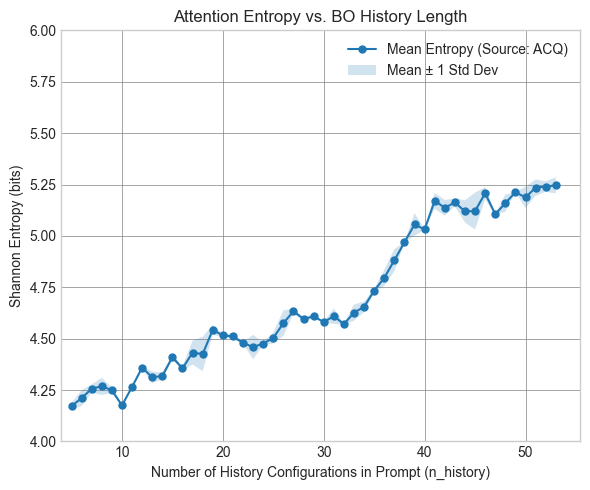

In [144]:
plot_entropy(json_filepath)

In [145]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_top_attended_tokens_as_heatmap_strip(
    last_token_dist, # Full 1D attention distribution from the last token
    num_top_tokens_to_show=20,
    title_prefix="Top Attended Tokens by Last Token (Heatmap Strip)",
    original_seq_len=None,
    token_id_to_string_fn=None, # Optional: maps original token index to token string
    cmap='viridis' # e.g., 'Blues', 'PuBu', 'viridis'
):
    """
    Identifies the top N tokens attended to by the last token and plots their
    attention weights as a horizontal heatmap strip, ordered by attention strength.

    Args:
        last_token_dist (np.array): The FULL 1D attention distribution from the last token.
        num_top_tokens_to_show (int): How many of the top attended tokens to display.
        title_prefix (str): Prefix for the plot title.
        original_seq_len (int, optional): Original sequence length for context.
        token_id_to_string_fn (function, optional): Function to get token strings.
        cmap (str): Colormap for the heatmap.
    """
    if last_token_dist is None:
        print(f"Warning: Cannot plot None last_token_dist for title: {title_prefix}")
        return

    if original_seq_len is None:
        original_seq_len = len(last_token_dist)

    if original_seq_len == 0:
        print(f"Warning: Original sequence length is 0. Cannot plot for: {title_prefix}")
        return

    # Get indices that would sort the attention distribution in descending order of weight
    sorted_indices_desc = np.argsort(last_token_dist)[::-1]

    # Select the top N tokens: their original indices and their attention weights
    num_to_plot = min(num_top_tokens_to_show, original_seq_len)
    top_original_indices = sorted_indices_desc[:num_to_plot]
    # The corresponding attention weights for these top tokens (already sorted high to low)
    top_attention_weights_sorted = last_token_dist[top_original_indices]

    # Reshape the (already sorted) top attention weights for heatmap plotting
    attention_reshaped = top_attention_weights_sorted.reshape(1, -1)  # Shape (1, num_to_plot)

    # Make squares bigger: Aim for cells to be visually distinct.
    cell_width_inch = 0.8 # Increased for "bigger squares" feel
    fig_width = num_to_plot * cell_width_inch + 2.0 # Base width + chrome
    fig_height = 3.0 # Height for one row of large cells, title, colorbar

    plt.figure(figsize=(fig_width, fig_height))

    ax = sns.heatmap(
        attention_reshaped,
        cmap=cmap,
        annot=True,       # Show attention values in cells
        fmt=".3f",        # Format for the annotations
        linewidths=0.5,    # Add lines between cells
        linecolor='gray',
        cbar_kws={'label': 'Attention Weight', 'orientation': 'horizontal', 'pad': 0.3, 'shrink': 0.7},
        yticklabels=[f"Top {num_to_plot} Attended"], # Label for the single row
        square=True,       # Make cells square
        vmin=0,  # <-- Set minimum value for color scale to 0
        vmax=1   # <-- Set maximum value for color scale to 1
    )

    title = f"{title_prefix}\n(Last Token to Top {num_to_plot} Attended Tokens, Sorted Left-to-Right by Weight)"
    ax.set_title(title, pad=15)
    # ax.set_xlabel("Original Identity of Attended Token (Sorted by Received Attention)")
    ax.set_ylabel("")

    # X-axis ticks and labels: These are the original indices (or string representations)
    # of the tokens that received the highest attention, ordered left-to-right by that attention.
    x_tick_labels = []
    if token_id_to_string_fn:
        # If you have a way to get the actual token strings based on original_input_ids
        # This example assumes token_id_to_string_fn takes the original index
        x_tick_labels = [f"'{token_id_to_string_fn(idx)}'\n(idx {idx})" for idx in top_original_indices]
    else:
        x_tick_labels = [f"{idx}" for idx in top_original_indices]
    
    tick_positions = np.arange(num_to_plot) + 0.5 # Center ticks for heatmap cells
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(x_tick_labels, rotation=45, ha="right")
            
    plt.tight_layout(rect=[0, 0.05, 1, 0.92]) # Adjust layout
    plt.show()




Plotting TOP ATTENDED TOKENS (by last token) as a sorted heatmap strip...


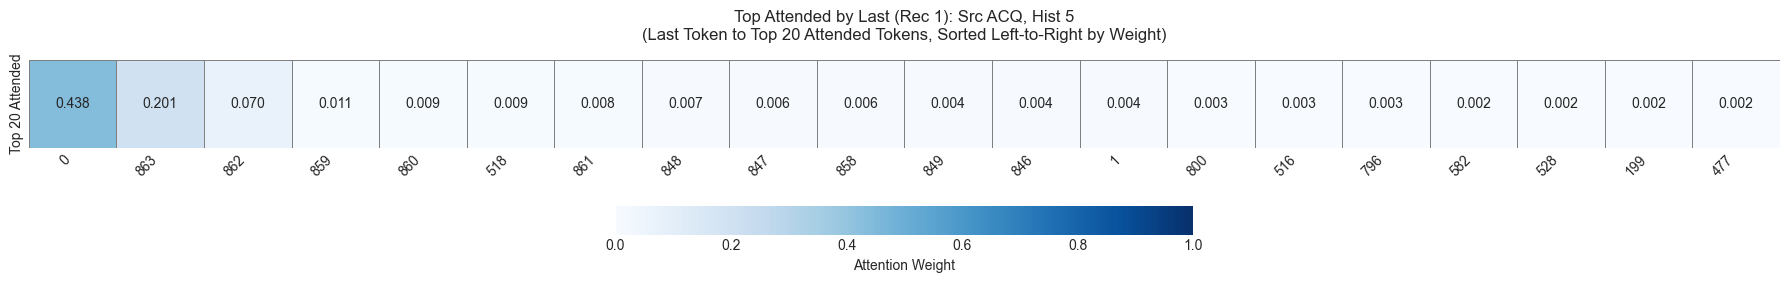

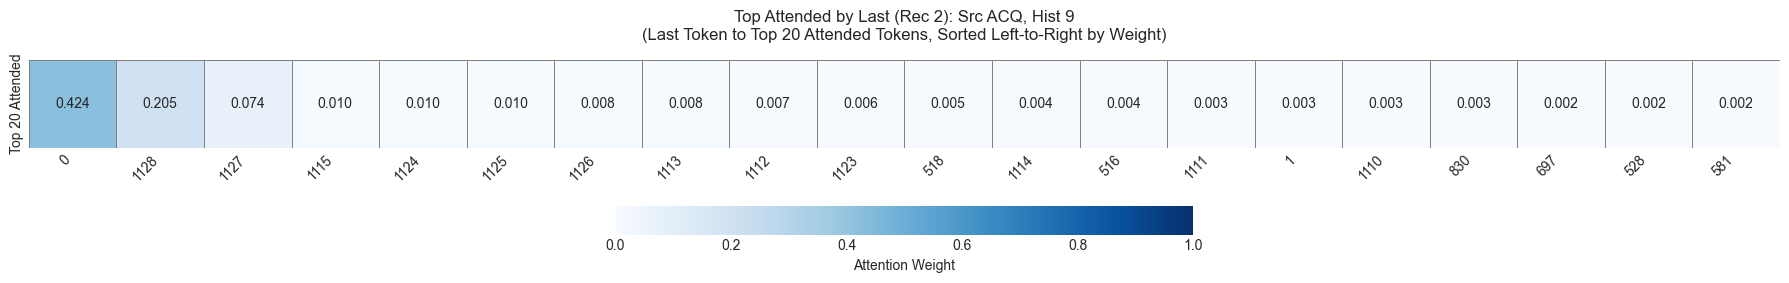

In [ ]:
# --- Example of using it with your loaded data: ---
if not attention_data_loaded: # Assuming 'attention_data_loaded' is your list of dicts
    print("No attention data loaded to plot.")
else:
    print("\nPlotting TOP ATTENDED TOKENS (by last token) as a sorted heatmap strip...")
    for i, record in enumerate(attention_data_loaded[:2]): # Plot for first 2 records
        if 'attention_matrix' in record and record['attention_matrix'] is not None:
            full_attention_matrix = record['attention_matrix']
            if full_attention_matrix.ndim == 2 and full_attention_matrix.shape[0] > 0:
                last_token_attention_dist = full_attention_matrix[-1, :]
                seq_len_for_this_record = record.get('seq_len', len(last_token_attention_dist))

                title_prefix = (f"Top Attended by Last (Rec {i+1}): "
                                f"Src {record.get('source_tag', 'N/A')}, "
                                f"Hist {record.get('n_history', 'N/A')}")
                

                plot_top_attended_tokens_as_heatmap_strip(
                    last_token_attention_dist,
                    num_top_tokens_to_show=20, # Show the top 15 most attended-to tokens
                    title_prefix=title_prefix,
                    original_seq_len=seq_len_for_this_record,
                    # token_id_to_string_fn=dummy_tokenizer_fn, # Pass your lookup function
                    cmap='Blues' # Example colormap
                )
            else:
                print(f"Record {i+1} has an invalid attention_matrix shape: {full_attention_matrix.shape}")
        else:
            print(f"Record {i+1} does not have a valid attention matrix.")


Plotting TOP ATTENDED TOKENS (by last token) as a sorted heatmap strip...


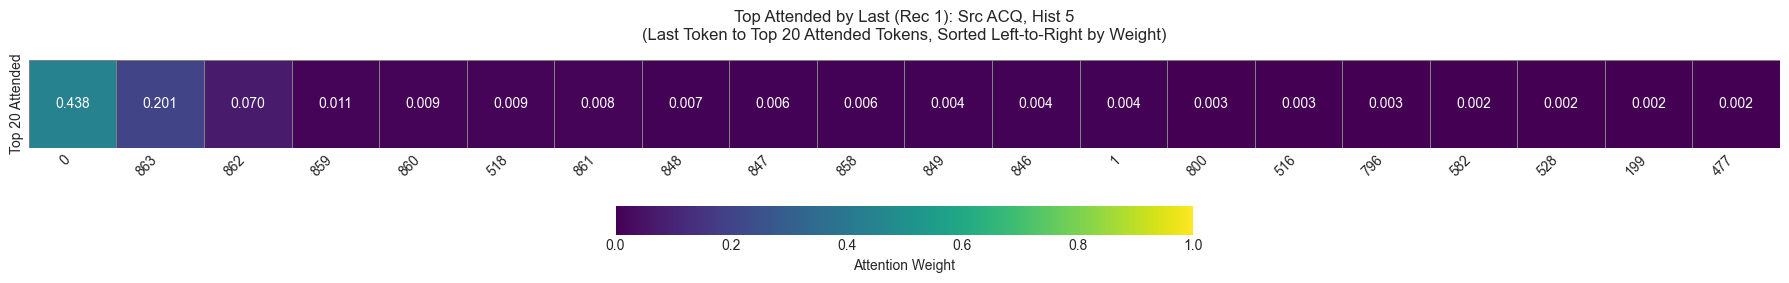

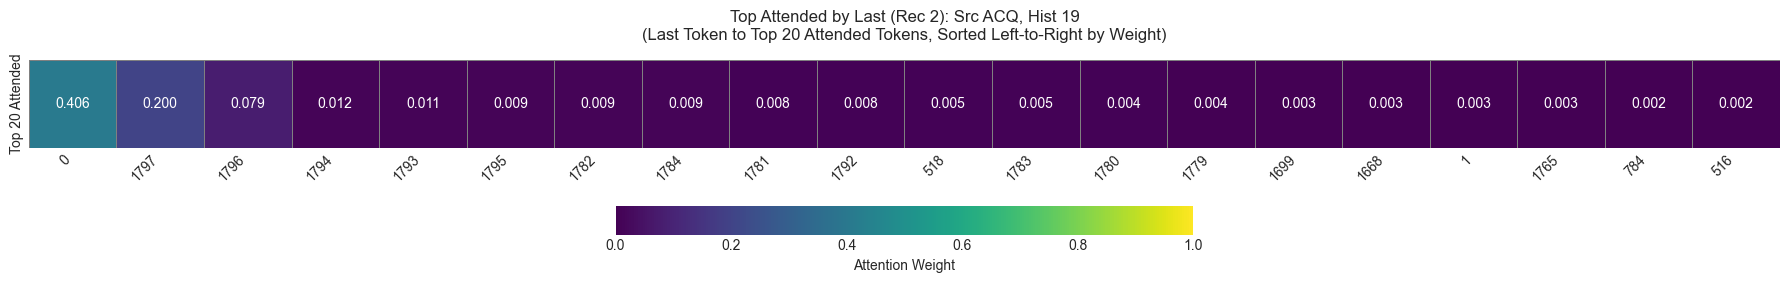

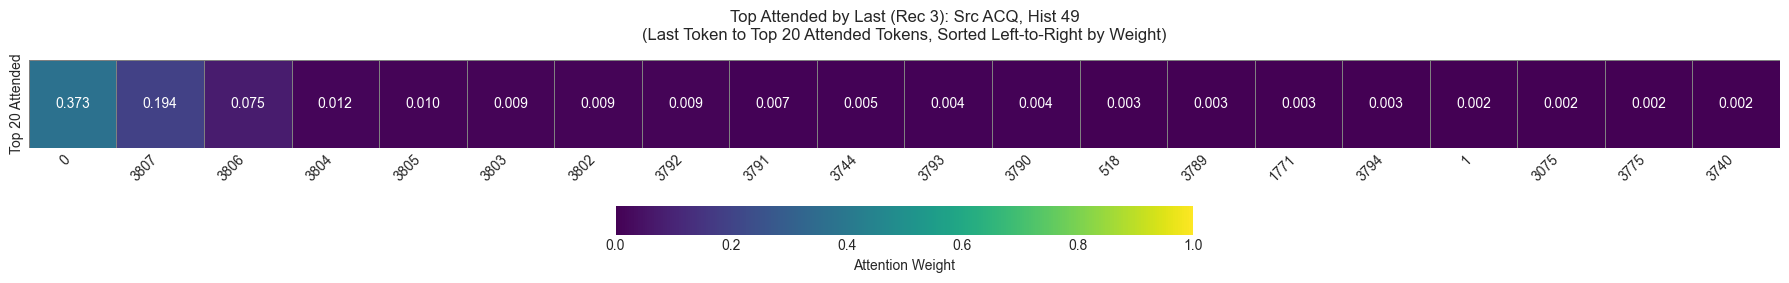

In [150]:
# --- Example of using it with your loaded data: ---
if not attention_data_loaded: # Assuming 'attention_data_loaded' is your list of dicts
    print("No attention data loaded to plot.")
else:
    print("\nPlotting TOP ATTENDED TOKENS (by last token) as a sorted heatmap strip...")

    indexes = [0, 3, 9]


    for i, index in enumerate(indexes):

    # for i, record in enumerate(attention_data_loaded[-2:]): # Plot for first 2 records
        record = attention_data_loaded[index]
        if 'attention_matrix' in record and record['attention_matrix'] is not None:
            full_attention_matrix = record['attention_matrix']
            if full_attention_matrix.ndim == 2 and full_attention_matrix.shape[0] > 0:
                last_token_attention_dist = full_attention_matrix[-1, :]
                seq_len_for_this_record = record.get('seq_len', len(last_token_attention_dist))

                title_prefix = (f"Top Attended by Last (Rec {i+1}): "
                                f"Src {record.get('source_tag', 'N/A')}, "
                                f"Hist {record.get('n_history', 'N/A')}")
                
                # Example token lookup (replace with your actual tokenizer logic if you have original IDs)
                # For demonstration, let's say you had the input_ids for this record
                # dummy_input_ids_for_record = np.arange(seq_len_for_this_record) 
                # def dummy_tokenizer_fn(original_idx):
                #     # In a real scenario, you'd use: tokenizer.decode(dummy_input_ids_for_record[original_idx])
                #     # or tokenizer.convert_ids_to_tokens(...) if you have subword IDs
                #     return f"tok[{original_idx}]"

                plot_top_attended_tokens_as_heatmap_strip(
                    last_token_attention_dist,
                    num_top_tokens_to_show=20, # Show the top 15 most attended-to tokens
                    title_prefix=title_prefix,
                    original_seq_len=seq_len_for_this_record,
                    # token_id_to_string_fn=dummy_tokenizer_fn, # Pass your lookup function
                    cmap='viridis' # Example colormap
                )
            else:
                print(f"Record {i+1} has an invalid attention_matrix shape: {full_attention_matrix.shape}")
        else:
            print(f"Record {i+1} does not have a valid attention matrix.")